# Faraday Dreams Real Data Example

Then recovery is performed using Faraday Dreams + Optimus Primal on real data.

In [646]:
import sys
sys.path.insert(0,'..')
#put path to optimusprimal git repo
sys.path.insert(0,'../../Optimus-Primal')
import optimusprimal.prox_operators as prox_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.primal_dual as primal_dual
import faradaydreams.measurement_operator as measurement_operator
import faradaydreams.models as models
import faradaydreams.plot_spectrum as plot_spectrum
import faradaydreams.convex_solvers as solvers
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

Reads the data and sets up the observation

[b'0515-674' b'1315-46' b'cena_c1093' b'cena_c1152' b'cena_c1435'
 b'cena_c1466' b'cena_c1573' b'cena_c1636' b'cena_c1640' b'cena_c1748'
 b'cena_c1764' b'cena_c1827' b'cena_c1832' b'cena_c1972' b'cena_s1014'
 b'cena_s1031' b'cena_s1290' b'cena_s1349' b'cena_s1382' b'cena_s1437'
 b'cena_s1443' b'cena_s1568' b'cena_s1605' b'cena_s1681' b'cena_s1803'
 b'lmc_c01' b'lmc_c02' b'lmc_c03' b'lmc_c04' b'lmc_c06' b'lmc_c07'
 b'lmc_c15' b'lmc_c16' b'lmc_s11' b'lmc_s13' b'lmc_s14']
b'lmc_c15'
0.0012131170369684696
2020-05-09 23:00:08,895 - Faraday Dreams - INFO - φ resolution 21.05379797599221 rad/m^2.
2020-05-09 23:00:08,896 - Faraday Dreams - INFO - φ max range is 111762.76439383144 rad/m^2.
2020-05-09 23:00:08,896 - Faraday Dreams - INFO - φ min range is 281.88765990411036 rad/m^2.


(0, 50)

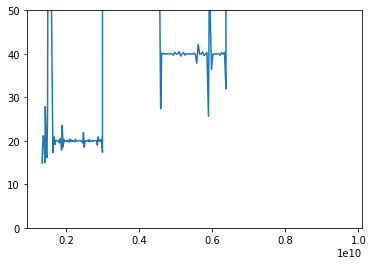

In [654]:
#data from http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/ApJ/825/59/table6
table_data = Table.read("../data/anderson_rms.vot")
sources = np.array(np.unique(table_data['ID']))
print(sources)
source = sources[-5]
print(source)
data = table_data[table_data['ID']==source]
y =  np.array(data['Q'] + 1j * data['U'])
weights_q = np.array(data['e_Q'])
weights_u = np.array(data['e_U'])
sigma = np.std(weights_q + 1j * weights_u) * 3
print(sigma)
c = 2.92 * 10**8 #speed of light m/s
m_size = len(y) #numbr of channels
freq0 = np.real(data["nu"]) * 10**9 # frequency coverage
dfreq = np.abs(50 * 10**6) # channel width
lambda2 = (c/freq0)**2 #wavelength^2 coverage
lambda1 = np.sqrt(lambda2) # wavelength coverage
dlambda2 = (c/(freq0 - dfreq/2.))**2 - (c/(freq0 + dfreq/2.))**2 #channel width in wavelength squared.
phi_max, phi_min, dphi = measurement_operator.phi_parameters(lambda2, dlambda2) #sensitivity estiamtes given coverage
phi = np.arange(-1e4, 1e4, dphi/2., dtype=float) # range in rad/m^2 to do reconstruction of signal
weights = np.abs(weights_q + 1j * weights_u)/sigma #choosing flat noise
rm_max = 1000

plt.plot(freq0[:-1], np.diff(freq0)/1e6)
plt.ylim([0, 50])

### Constructing the measurement matrix
The measurement process can be written in the measurement equation
$$P(\lambda^2) = \int P(\phi) a(\lambda^2, \phi) {\rm e}^{2 i \lambda^2 \phi}\Delta \phi \, ,$$
which maps Faraday Depth $\phi$ to the measured wavelength $\lambda^2$ for $P = Q +iU$.
The measurement matrix is determined by the following sum: 
$$P(\lambda^2_p) = \sum_{k=0}^N P(\phi_k) a(\lambda^2_p, \phi_k) {\rm e}^{2 i \lambda^2_p \phi_k}\Delta \phi_k$$
where $P$ is the complex polarization signal. $a$ is the impact of channel averaging (it has a constant value of 1 when there is no averaging). It is a Fourier series between $\lambda^2$ and $\phi$.

We can write this as $$\mathbf{y} = \mathbf{\mathsf{\Phi}}\mathbf{x}$$ since it is a system of linear equations.

In [655]:
# measurement operator with channel averaging
m_op_right = measurement_operator.faraday_operator(lambda2, phi, weights, dlambda2)
m_op_wrong = measurement_operator.faraday_operator(lambda2, phi, lambda2* 0 + 1)
#switch to see how important channel averaging is
m_op = m_op_right

Below we also create a version (for comparing no channel averaging) where $a(\lambda^2_p, \phi_k) = 1$

In [656]:
# measurement operator without channel averaging
lambda2_high_res = np.linspace(np.min(lambda2), np.max(lambda2), 1024)
lambda1_high_res = np.sqrt(lambda2_high_res)
m_op_no_averaging = measurement_operator.faraday_operator(lambda2_high_res, phi, lambda2_high_res * 0 + 1)

Below we plot our measured signal in $\lambda^2$ (wavelength squared $m^2$) with and without channel averaging (top panel), and compare the absolute value of the measured signal in $\phi$ (Faraday Depth, rad/m$^2$) against the ground truth (bottom panel). 

The missing Fourier coefficients in $\lambda^2$ make the blue curve very different from the original (yellow).

Text(0, 0.5, '(Jy)')

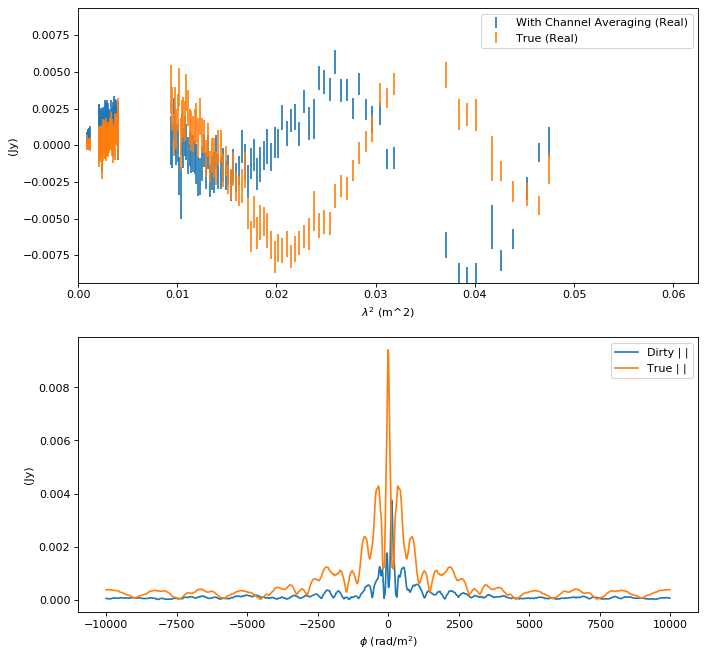

In [657]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=80)
ax[0].errorbar(lambda2, np.real(y), yerr=weights * sigma/np.sqrt(2), fmt='',linestyle='')
ax[0].errorbar(lambda2, np.imag(y), yerr=weights * sigma/np.sqrt(2), fmt='',linestyle='')
ax[0].set_ylim([-np.max(np.abs(y)),np.max(np.abs(y))])
ax[0].set_xlim([0,0.25**2])
ax[0].set_xlabel(r"$\lambda^2$ (m^2)")
ax[0].set_ylabel(r"(Jy)")
ax[0].legend(["With Channel Averaging (Real)", "True (Real)", "With Channel Averaging (Imag)", "True (Imag)"])
ax[1].plot(phi, np.abs(m_op.adj_op(y * weights)) * 1./len(y))
ax[1].plot(phi, np.abs(m_op.adj_op((y * 0. + 1) * weights/np.sum(weights))) * 1./len(y))
ax[1].legend(["Dirty | |", "True | |", "Solution | |"])
ax[1].set_xlabel(r"$\phi$ (rad/m$^2$)")
ax[1].set_ylabel(r"(Jy)")
#ax[1].set_xlim([-rm_max, rm_max])

Below you can choose assumptions about how to fit the true signal. You can choose wavelets or not (dirac is no wavelets). I suggest no wavelets for now

In [664]:
#choose basis for enforce sparisty (dirac seems to be the best choice, but it depends on wavelength coverage!)
#wav = ["dirac", "db2", "db4", "db6", "db8"]
wav = ["db8", "dirac"]
#wav = ["dirac"]
levels = 4 #wavelet levels, makes no difference for dirac

In [665]:
# you can choose the convergence criteria of the algorithm
options = {'tol': 1e-6, 'iter': 50000, 'update_iter': 1000, 'record_iters': False} #algorithm properties
beta= 1e-3 #stepsize that you might have to change 1e-2 to 1e-4 are normally okay, change if result looks bad

Here we run the convex optimization algorithm. It solves a minimization problem that compromizes between least squares fitting and using a minimal amount of parameters (occams razor, sparsity) to avoid over fitting.

In [666]:
#get solution of algo and run
nu, sol = linear_operators.power_method(m_op_right, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
solution_right, diag_right = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_right, wav, levels, nu, beta, options)

2020-05-09 23:00:38,958 - Optimus Primal - INFO - Starting Power method
2020-05-09 23:00:38,961 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-05-09 23:00:38,967 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-05-09 23:00:38,970 - Optimus Primal - INFO - [Power Method] Converged with iter = 15, tol = 9.128628929004043e-05
2020-05-09 23:00:38,971 - Faraday Dreams - INFO - Using wavelets ['db8', 'dirac'] with 4 levels
2020-05-09 23:00:38,972 - Faraday Dreams - INFO - Using an estimated noise level of 0.0012131170369684696 (weighted image units, i.e. Jy/Beam)
2020-05-09 23:00:38,975 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-05-09 23:00:38,979 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2020-05-09 23:00:38,984 - Optimus Primal - INFO - [Primal Dual] 0 out of 50000 iterations, tol = 0.222355
2020-05-09 23:00:40,706 - Optimus Primal - INFO - [Primal Dual] 1000 out of 50000 iteration

In [667]:
#get solution of algo and run
nu, sol = linear_operators.power_method(m_op_wrong, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
solution_wrong, diag_wrong = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_wrong, wav, levels, nu, beta, options)

2020-05-09 23:01:01,482 - Optimus Primal - INFO - Starting Power method
2020-05-09 23:01:01,486 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2020-05-09 23:01:01,493 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2020-05-09 23:01:01,498 - Optimus Primal - INFO - [Power Method] iter = 21, tol = 0.0
2020-05-09 23:01:01,502 - Optimus Primal - INFO - [Power Method] iter = 31, tol = 0.0
2020-05-09 23:01:01,512 - Optimus Primal - INFO - [Power Method] iter = 41, tol = 0.0
2020-05-09 23:01:01,519 - Optimus Primal - INFO - [Power Method] Converged with iter = 44, tol = 8.82991198743734e-05
2020-05-09 23:01:01,521 - Faraday Dreams - INFO - Using wavelets ['db8', 'dirac'] with 4 levels
2020-05-09 23:01:01,522 - Faraday Dreams - INFO - Using an estimated noise level of 0.0012131170369684696 (weighted image units, i.e. Jy/Beam)
2020-05-09 23:01:01,526 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2020-05-09 23:01:01,530 - O

Below we calculate some comparisons to plot against the model. This involes ground truth, measured, and fitted model.

In [668]:
y_right = m_op_right.dir_op(solution_right) 
y_wrong = m_op_wrong.dir_op(solution_wrong) 
y_model_right = m_op_no_averaging.dir_op(solution_right) 
y_model_wrong = m_op_no_averaging.dir_op(solution_wrong) 

116.34992746502212
116.34992746502212


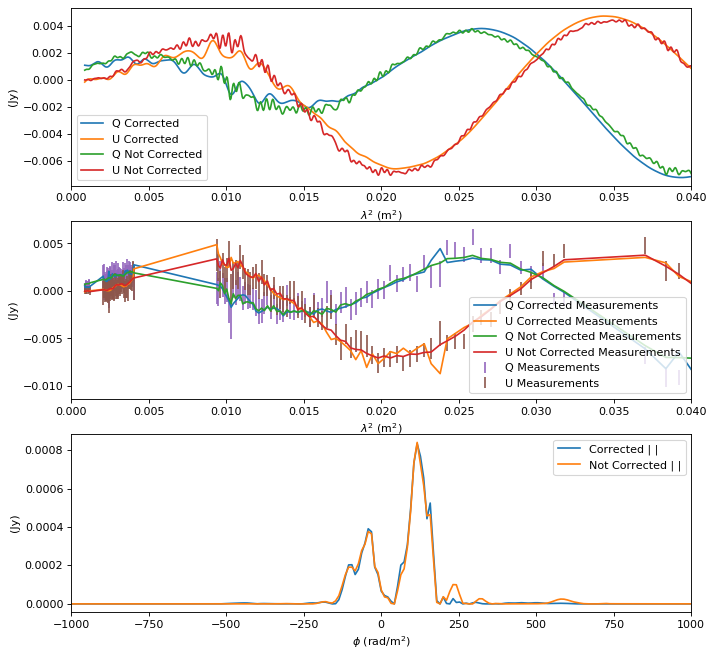

In [669]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), dpi=80)
ax[0].plot(lambda2_high_res, np.real(y_model_right))
ax[0].plot(lambda2_high_res, np.imag(y_model_right))
ax[0].plot(lambda2_high_res, np.real(y_model_wrong))
ax[0].plot(lambda2_high_res, np.imag(y_model_wrong))
ax[0].set_xlim([0., 0.2**2])
ax[0].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[0].set_ylabel(r"(Jy)")
ax[0].legend(["Q Corrected", "U Corrected", "Q Not Corrected", "U Not Corrected"])
ax[1].plot(lambda2, np.real(y_right))
ax[1].plot(lambda2, np.imag(y_right))
ax[1].plot(lambda2, np.real(y_wrong))
ax[1].plot(lambda2, np.imag(y_wrong))
ax[1].errorbar(lambda2, np.real(y), yerr=weights * sigma/np.sqrt(2), fmt='',linestyle='')
ax[1].errorbar(lambda2, np.imag(y), yerr=weights * sigma/np.sqrt(2), fmt='',linestyle='')
ax[1].set_xlim([0., 0.2**2])
ax[1].set_xlabel(r"$\lambda^2$ (m$^2$)")
ax[1].set_ylabel(r"(Jy)")
ax[1].legend(["Q Corrected Measurements", "U Corrected Measurements", "Q Not Corrected Measurements", "U Not Corrected Measurements","Q Measurements", "U Measurements",])
#ax[2].plot(phi, np.abs(m_op.adj_op(y)) * 1./len(y))
ax[2].plot(phi, np.abs(solution_right))
ax[2].plot(phi, np.abs(solution_wrong))
ax[2].legend([ "Corrected | |", "Not Corrected | |"])
ax[2].set_xlabel(r"$\phi$ (rad/m$^2$)")
ax[2].set_ylabel(r"(Jy)")
ax[2].set_xlim([-rm_max, rm_max])
print(phi[np.argmax(np.abs(solution_right))])
print(phi[np.argmax(np.abs(solution_wrong))])